In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os

In [16]:
def transform_batch(X,Y):
    params = np.random.random((X.shape[0], 3))
    params[:,0] = np.floor(params[:,0]*4)
    params[:,1] *= 0.2
    params[:,2] = (params[:,2]-0.5)*0.2

    X2 = X.copy()
    Y2 = Y.copy()

    # Orientation
    do_vswap = (params[:,0]==1)+(params[:,0]==3)
    do_hswap = (params[:,0]==2)+(params[:,0]==3)
    X2[do_vswap] = X2[do_vswap,::-1,:,:]
    X2[do_hswap] = X2[do_hswap,:,::-1,:]
    Y2[do_vswap] = Y2[do_vswap,::-1,:,:]
    Y2[do_hswap] = Y2[do_hswap,:,::-1,:]

    # Noise & illumination
    for i in range(X2.shape[0]):
        X2[i] += np.random.random(X2[i].shape)*params[i,1]-params[i,1]/2+params[i,2]

    return X2,Y2

def feed(path, seed=0, batch_size=20):
    np.random.seed(seed)

    files = os.listdir(path)
    segfiles = [f for f in files if f.find('png_seg.npy') > 0]
    basefnames = [f.replace('.png_seg.npy','') for f in segfiles]

    # Preload all coordinates
    coordinates = {}
    for b in basefnames:
        coordinates[b] = np.load(os.path.join(path,'%s_coordinates.npy'%b))

    tile_size = coordinates[b][0,2]-coordinates[b][0,0]

    N = len(basefnames)
    idxs = np.arange(N)
    np.random.shuffle(idxs)

    for idx in idxs:
        b = basefnames[idx]
        idc = np.arange(coordinates[b][coordinates[b][:,4]==1].shape[0])
        im = plt.imread(os.path.join(path,'%s.png'%b))[:,:,:3]
        seg = np.load(os.path.join(path,'%s.png_seg.npy'%b))
        np.random.shuffle(idc)
        coords = coordinates[b][coordinates[b][:,4]==1][idc[:batch_size]]
        X = np.zeros((batch_size,tile_size,tile_size,3))
        Y = np.zeros((batch_size,tile_size,tile_size,1))
        for i,c in enumerate(coords):
            X[i] = im[c[1]:c[1]+tile_size,c[0]:c[0]+tile_size,:]
            Y[i,:,:,0] = seg[c[1]:c[1]+tile_size, c[0]:c[0]+tile_size]
        yield transform_batch(X,Y),(X,Y)

In [3]:
batches = "E:\\data\\201702-scans\\images"

In [17]:
for batch in feed(batches, 0):
    break

In [18]:
X2 = batch[0][0]
Y2 = batch[0][1]
X = batch[1][0]
Y = batch[1][1]

In [27]:
imscale = lambda X : (X-X.min())/(X.max()-X.min()) 

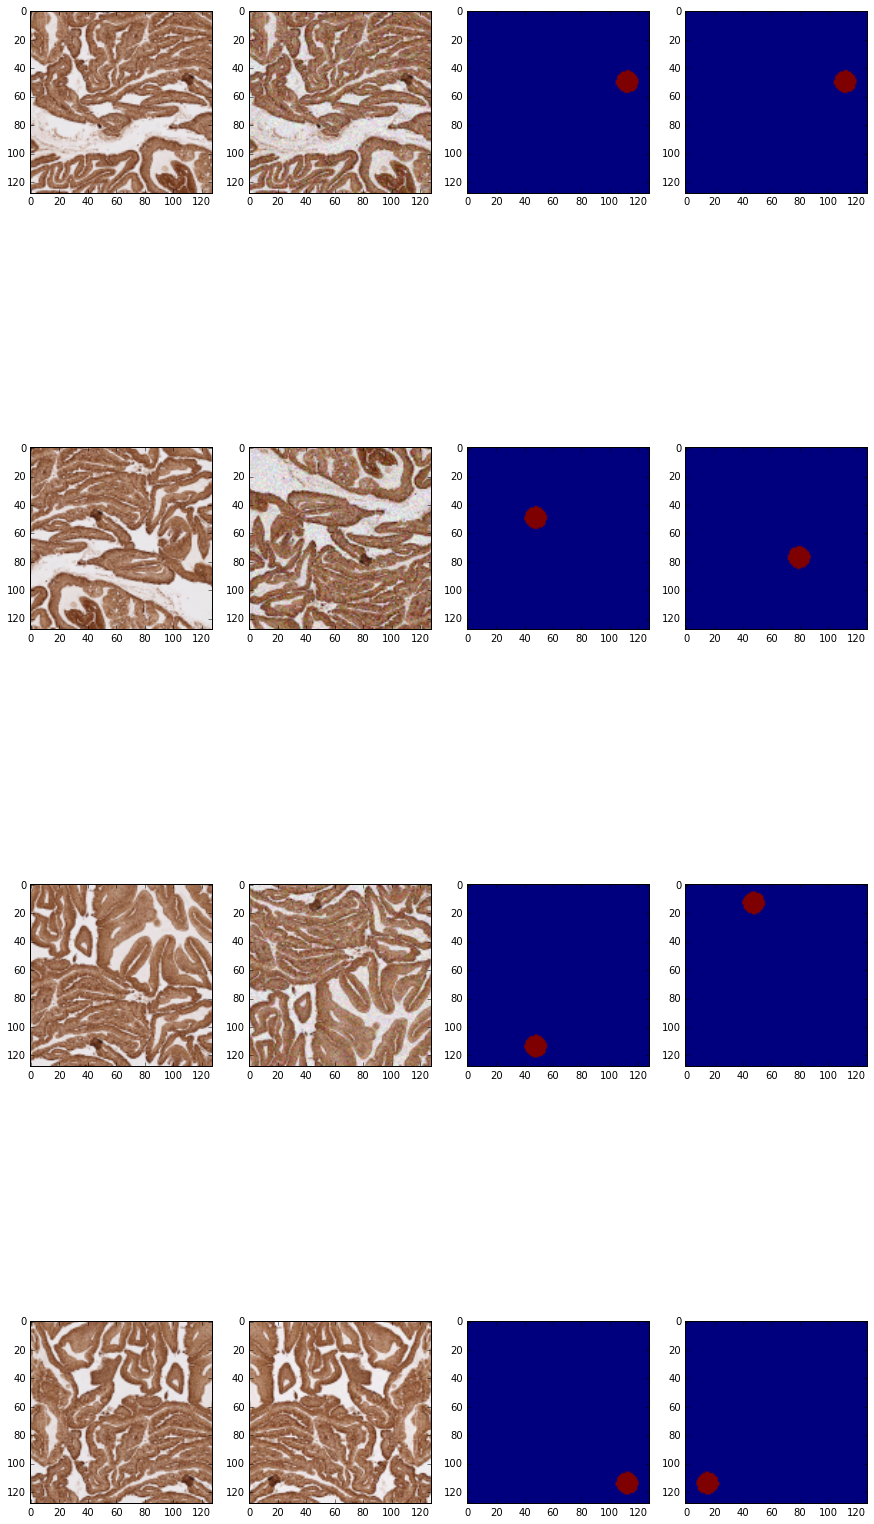

In [38]:
plt.figure(figsize=(15,30))
for t in range(4):
    plt.subplot(4,4,t*4+1)
    plt.imshow(X[t])
    plt.subplot(4,4,t*4+2)
    plt.imshow(imscale(X2[t]))
    plt.subplot(4,4,t*4+3)
    plt.imshow(Y[t,:,:,0])
    plt.subplot(4,4,t*4+4)
    plt.imshow(Y2[t,:,:,0])
plt.show()

In [31]:
print((X2[0]-X[0]).min(), (X2[0]-X[0]).max())

(-0.027618569763461442, 0.13888966318777807)
